# Evolving Population: Fitness shift towards optimal

In this notebook we focus on reproducing the evolution of population fitness distribution. Our end goal is to visualize fitness distributions of multiple steps of TS-DE. With this plot, we show how TS-DE iteratively shifts the fitness distribution towards the maximum value.

In [1]:
%%time

from tqdm import tqdm
import sys
import math
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

sys.path.append('../')

from util.common import zero_population, linear_bayesian_utility_model
from util.TS_DE.TS_DE import TS_DE


CPU times: total: 250 ms
Wall time: 284 ms


**Reproducing right-hand side Figure 6.2.:**

**Parameter setup:**
- *d=40*
- *M=20*
- *T=60*
- *mu=0.1*
- *sigma=1*
- *lambda_=1*

**Claims we are testing:**
(4) In TS-DE the population's fitness distribution shifts towards optimal during evolution.

In [2]:
%%time

np.random.seed(seed=0)

# Initial setting for TS-DE and DE
d = 40
M = 20
T = 60
mu = 0.1
n_evals = 100

# Theta star - optimal theta - parametrization of the linear Bayesian utility model for
# which we aim to optimize the protein design.
theta_star = np.random.multivariate_normal(np.zeros(d), np.eye(d))

# Sequence that maximizes the utility function (used for visualizations).
x_star = [0 if theta_i < 0 else 1 for theta_i in theta_star]
max_fitness = linear_bayesian_utility_model(x=x_star, theta=theta_star)

CPU times: total: 0 ns
Wall time: 245 µs


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


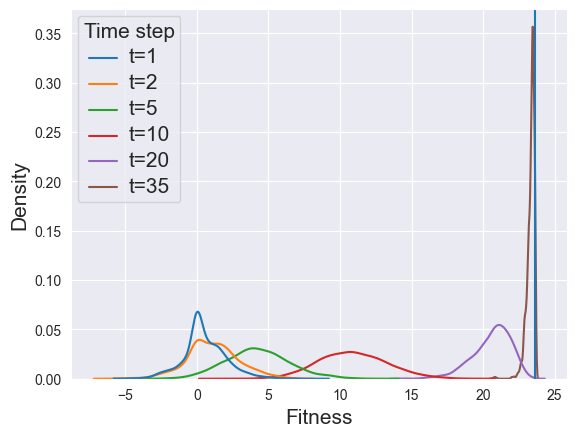

CPU times: total: 1min 53s
Wall time: 1min 2s


In [3]:
%%time

data = []
for _ in tqdm(range(n_evals)):
    # Execute TS-DE
    populations, thetas = TS_DE(d=d,
                                T=T,
                                M=M,
                                theta_star=theta_star,
                                S_0=zero_population(d=d, M=M),
                                mu=mu,
                                sigma=1,
                                lambda_=1,
                                f=linear_bayesian_utility_model)
    for i in [1, 2, 5, 10, 20, 35]:
        S = populations[i]
        data.extend(
            [
                {'Time step': f't={i}', 'fitness f(x)': linear_bayesian_utility_model(x=x, theta=theta_star)} for x in S
            ]
        )

plot = sns.kdeplot(data=pd.DataFrame(data), x='fitness f(x)', hue='Time step')
plot.set_xlabel('Fitness', fontsize='15')
plot.set_ylabel('Density', fontsize='15')

plt.setp(plot.get_legend().get_texts(), fontsize='15')
plt.setp(plot.get_legend().get_title(), fontsize='15')

plt.axvline(x=max_fitness, label='Max fitness')
plt.savefig('../plots/evolving_population_fitness.png')
plt.show()